In [1]:
using LinearAlgebra
using DelimitedFiles
using PyPlot
using Random
using LinearAlgebra
using Statistics
using DCAUtils
using StatsBase
using Distributions
using Graphs

In [241]:
include("energy.jl");
include("MontecarloUtils2.jl");
include("dATline.jl")

stability_analysis (generic function with 1 method)

### dAT line code 

In [3]:
function initialize_pars(L::Int, Connectivity::Int, R::Float64)
    p = Connectivity/(L-1)

    ### Initialize seed RNG
    RNGseed = 10
    Random.seed!(RNGseed)
    
    h=zeros(L)
    
    J = zeros(Float64,L,L)
    for i = 1:L
        for j = i+1:L
            if rand() < p
                Jvalue = 1.0 ## Fixed ferromagnetic couplings
                J[i,j] = Jvalue
                J[j,i] = Jvalue
            end
        end
    end

    return h,J
end

initialize_pars (generic function with 1 method)

## Phase Transition of RRG with fixed Connectivity

In [21]:
function CritT(J_scale::Float64, Connectivity::Int)
    return J_scale/(atanh(1/(Connectivity-1)))
end

CritT (generic function with 1 method)

In [275]:
L = 300
C = 4
g = random_regular_graph(L, C)
h0 = zeros(L)
J0 = zeros(L,L)
J_scale = 1.
for i in 1:L
    for n in g.fadjlist[i]
        J0[i,n] = J_scale
    end
end  
Iterations = 100

@time U, Δ, ev_u, avPert, maxPert = dATlineSearch(Iterations,Iterations,1.,T,h0,J0);

  1.926035 seconds (54.60 M allocations: 1.699 GiB, 7.89% gc time)


In [276]:
Iterations = 30
Ts = [2. + 5e-2*i for i in 1:40] 
res = []
for T in Ts
    matr = stability_analysis(Iterations,T,h0,J0)
    l, vv = eigen(matr);
    push!(res, maximum(abs.(l)))
end

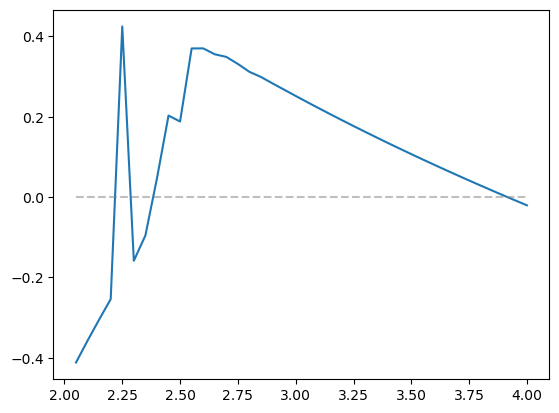

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6cbe006dc0>

In [277]:
plt.plot(Ts, log.(res))
plt.plot(Ts, [0. for i in 1:length(Ts)], color = "grey", linestyle = "--", alpha = 0.5)

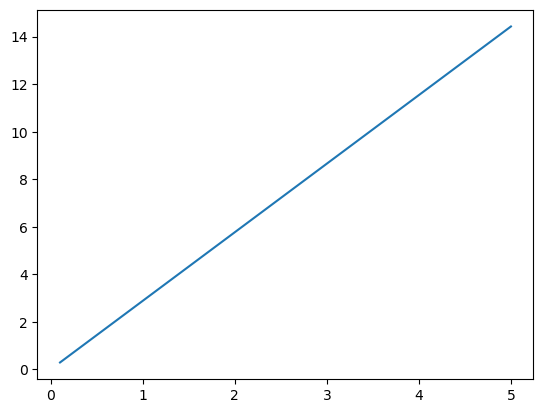

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6cc339d880>

In [141]:
C = 4 #Graph Connectivity
J_scales = [1e-1*i for i in 1:50]
T_theor = [CritT(Js, C) for Js in J_scales] #Critical temperature
plt.plot(J_scales, T_theor)


In [142]:
1/(atanh(1/3))

2.8853900817779268

In [173]:
L = 100
C = 3 #Graph Connectivity
J_scales = [1e-1*i for i in 1:20] #coupling scale
T_theor = [CritT(Js, C) for Js in J_scales] #Critical temperature
g = random_regular_graph(L, C)
h0 = zeros(L)
J0 = zeros(L,L)
J_scale0 = 1.
for i in 1:L
    for n in g.fadjlist[i]
        J0[i,n] = J_scale0
    end
end   
Iterations = 30


x = []; y = []; z = []; z_max = []; 

start = time()
for i in 1:length(J_scales) 
    Ts = [1e-1*n for n in 1:100]
    println(i)
    h = h0
    J = J0 .* J_scales[i]
    for T in Ts
        U, Δ, ev_u, avPert, maxPert = dATlineSearch(Iterations,Iterations,1.,T,h,J)
        push!(x, J_scales[i])
        push!(y,T)
        push!(z, avPert[end])
        push!(z_max, maxPert[end])
    end
end
fine = time()
println(fine-start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
109.02596592903137


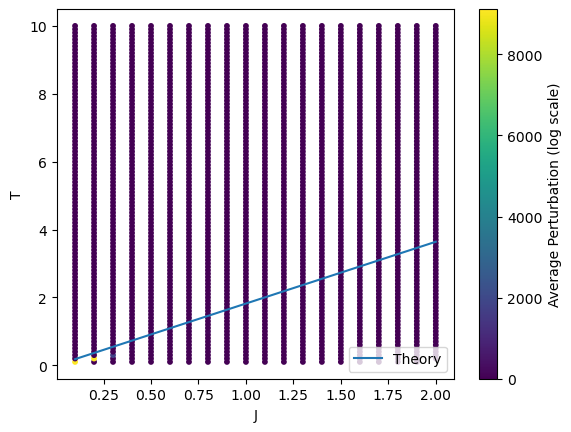

PyObject <matplotlib.legend.Legend object at 0x7f6cbe7cfa30>

In [177]:
plt.scatter(x, y, c = z, s = 10, cmap="viridis")
plt.plot(J_scales, T_theor, label = "Theory")
plt.colorbar(label = "Average Perturbation (log scale)")  # Aggiunge una barra dei colori
plt.ylabel("T")
plt.xlabel("J")
plt.legend()
#savefig("../mean_phase_transition.png")

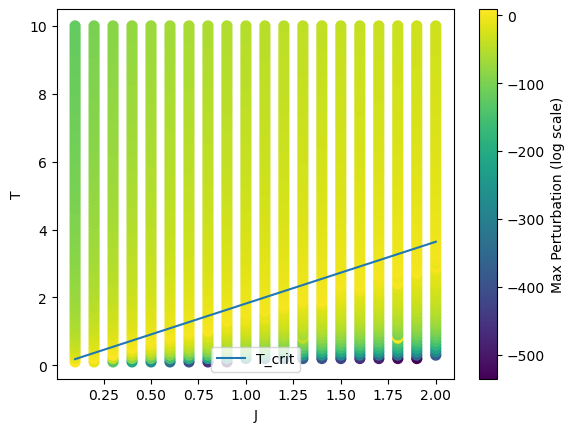

In [180]:
plt.scatter(x, y, c=log.(z), s = 50, cmap="viridis")
plt.plot(J_scales, T_theor, label = "T_crit")
plt.colorbar(label = "Max Perturbation (log scale)")  # Aggiunge una barra dei colori
plt.ylabel("T")
plt.xlabel("J")
plt.legend()
savefig("../max_phase_transition.png")

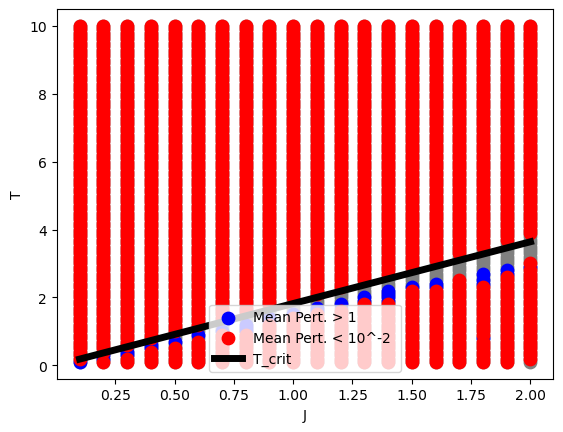

In [181]:
tresh = 1e-2
metric = z

plt.scatter(x, y, color = "grey", s = 80)
plt.scatter(x[metric.>100*tresh], y[metric.>100*tresh], color = "blue", label = "Mean Pert. > 1 ", s = 80)
plt.scatter(x[metric.<tresh], y[metric.<tresh], color = "red",label = "Mean Pert. < 10^-2 ", s = 80)
plt.plot(J_scales, T_theor, color = "black", linewidth = 5.0, label = "T_crit")
plt.ylabel("T")
plt.xlabel("J")
plt.legend()
savefig("../mean_binary_phase_transition.png")

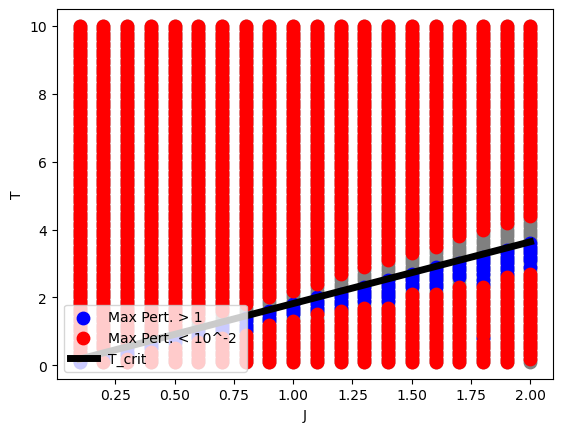

In [182]:
tresh = 1e-2
metric = z_max

plt.scatter(x, y, color = "grey", s = 80)
plt.scatter(x[metric.>100*tresh], y[metric.>100*tresh], color = "blue", label = "Max Pert. > 1 ", s = 80)
plt.scatter(x[metric.<tresh], y[metric.<tresh], color = "red",label = "Max Pert. < 10^-2 ", s = 80)
plt.plot(J_scales, T_theor, color = "black", linewidth = 5.0, label = "T_crit")
plt.ylabel("T")
plt.xlabel("J")
plt.legend()
savefig("../max_binary_phase_transition.png")

## Reproducing Saverio results for Viana-Bray model

In [3]:
function compute_freq(msa::Matrix{Int64})
    M,L = size(msa)
    freqs = zeros(2,L)
    for m in 1:M
        for i in 1:L
            if msa[m,i] == 1
                freqs[1,i] += 1
            else
                freqs[2,i] += 1
            end
        end
    end
    return freqs/M
end

function entr(f::Matrix{Float64})
    q,L = size(f)
    entropy = zeros(L)
    for i in 1:L
        for a in 1:q
            if f[a,i] > 0.
                entropy[i] -= f[a,i]*log(f[a,i])
            end
        end
    end
    return entropy./log(2)
end

function proba_cond(seq::Array{Int64,1}, h::Array{Float64,1}, J::Array{Float64,2}, T::Float64)
    L = size(seq,1)
    p = zeros(2,L)
    for i in 1:L
        count = h[i]
        for j in 1:L
            count+= J[i,j]*seq[j]
        end
        p[1,i] = exp(count/T)
        p[2,i] = exp(-count/T)
        p[:,i] ./= (exp(count/T)+exp(-count/T))
    end
    return p
end


function rand_S(length::Int)
    # Generate a random sequence of 0 and 1
    random_zeros_ones = rand(0:1, length)
    # Convert 0 to -1
    random_sequence = 2 .* random_zeros_ones .- 1
    return Int.(random_sequence)
end

function Multiple_MCMC_Metropolis(nsamples::Int, nsteps::Int, seq::Array{Int,1}, L::Int, h::Array{Float64,1}, J::Array{Float64,2}, β::Float64; RandomInitial::Bool=false)

    """
    Function to perform many MonteCarlo trajectories with the Metropolis setting.

    parameters:
    - nsamples: number of samples to be computed
    - nsteps: the number of steps to be performed
    - seq: the initial configuration
    - L: the size of the system
    - h: the local fields  
    - J: the couplings 
    - β: inverse temperature used to compute the probability
    - RandomInitial: if true ignore the initial configuration and choose a random one for each sample

    output:
    - MSA: MSA of configurations after nsteps
    """ 

    evolving_MSA = zeros(Int64,(nsamples,L))

    if RandomInitial
        for s in 1:nsamples
            for i = 1:L
                if rand() > 0.5
                    evolving_MSA[s,i] = 1
                else
                    evolving_MSA[s,i]= -1
                end
            end
        end
    else
        for s in 1:nsamples
            evolving_MSA[s,:] = copy(seq)
        end
    end

    for s in 1:nsamples
        evolving_MSA[s,:] .= MCMC_Metropolis(nsteps,evolving_MSA[s,:], L, h, J, β)
    end

    return evolving_MSA
end

Multiple_MCMC_Metropolis (generic function with 1 method)

In [4]:
L = 100 
Connectivity = 4  ## Average connectivity of the model
p = Connectivity/(L-1)
R = 0.5 ## Standard deviation used to extract random couplings


### Initialize seed RNG
RNGseed = 10
Random.seed!(RNGseed)


### Initialize fields & couplings
# h = zeros(Float64,L) ## No fields
# FieldDistribution = Normal(0,0.02) ## Gaussian fields
FieldDistribution = Laplace(0,0.5) ## Laplace fields (symmetric exponential)
# FieldDistribution = Truncated(Cauchy(0,0.5),-100,100) ## Cauchy fields
h=rand(FieldDistribution, L)  

J = zeros(Float64,L,L)
for i = 1:L
    for j = i+1:L
        if rand() < p
            # Jvalue = 1.0 ## Fixed ferromagnetic couplings
            Jvalue = rand(Normal(0,R))
            J[i,j] = Jvalue
            J[j,i] = Jvalue
        end
    end
end


### Check that J is symmetric
for i in 1:L
    for j in 1:L
        @assert J[i,j] == J[j,i]
    end
end



In [27]:
S = zeros(Int,L)
for i = 1:L
    if rand() > 0.5
        S[i] = 1
    else
        S[i] = -1
    end
end

In [6]:
list = readdlm("CouplingsFields_Connectivity4_seed10_L100")
J = zeros(L,L)
h = zeros(L)
for n in 1:size(list,1)
    if typeof(list[n,3]) == Float64
        J[list[n,1],list[n,2]] = list[n,3]
        J[list[n,2],list[n,1]] = list[n,3]
    else
        h[list[n,1]] = list[n,2]
    end 
end    

In [7]:
"""S = [1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 
    -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 
    1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 
    1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 
    -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 
    -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1];


In [10]:
start_seq = 
Nsamples = 500
Nsteps = 1000000
T = 0.65
@time eq_seq = Multiple_MCMC_Metropolis(Nsamples,Nsteps,S,L,h,J,1/T);

LoadError: InterruptException:

In [358]:
Nsamples = 500
Nsteps = 1000000
T = 0.65
eq_seq = Int.(ones(Nsamples,L))
for i in 1:Nsamples
    eq_seq[i,:] = MCMC_Metropolis(Nsteps,rand_S(L),L,h,J,1/T)
end

In [126]:
T = 0.65
β = 1.0/T
Nsamples = 500
Nsteps = 10000
@time eq_seq = Multiple_MCMC_Metropolis(Nsamples,Nsteps,S,L,h,J,β;RandomInitial=true);

  4.720728 seconds (20.00 M allocations: 5.114 GiB, 15.20% gc time)


  0.000373 seconds (2 allocations: 3.531 KiB)


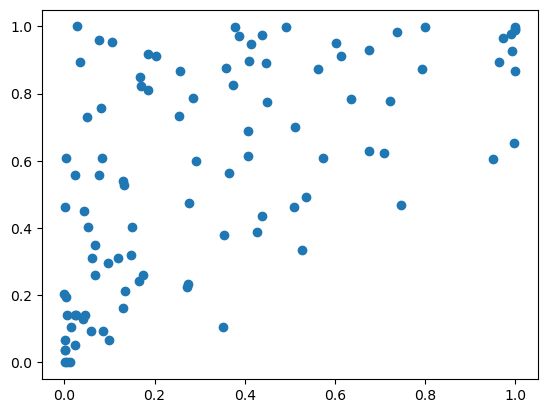

PyObject <matplotlib.collections.PathCollection object at 0x7f790ae58490>

In [127]:
p_wt = proba_cond(eq_seq[10,:],h,J,T)
cde = entr(p_wt);
@time f_eq = compute_freq(eq_seq)
cie = entr(f_eq);
scatter(cde,cie)

In [134]:
Ts = [0.65 + 0.1* i for i in 1:10]
mean_cie = []
std_cie = []
for T in Ts
    β = 1.0/T
    Nsamples = 500
    Nsteps = 10000
    eq_seq = Multiple_MCMC_Metropolis(Nsamples,Nsteps,S,L,h,J,β;RandomInitial=true)
    f_eq = compute_freq(eq_seq)
    cie = entr(f_eq)
    push!(mean_cie, mean(cie))
    push!(std_cie, std(cie))
end 


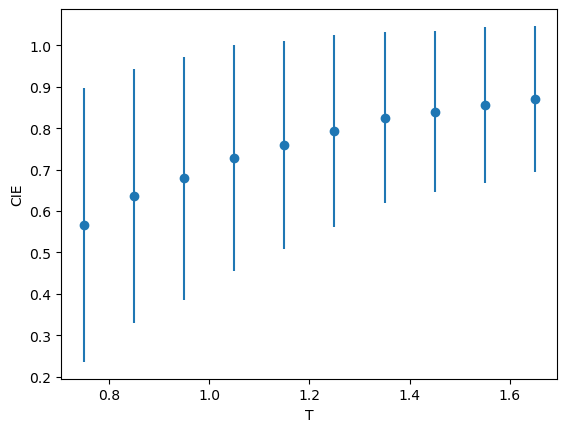

In [141]:
plt.errorbar(Ts, mean_cie, yerr = std_cie, fmt = "o")
plt.xlabel("T")
plt.ylabel("CIE")
savefig("cie_varyingT.png")

In [137]:
xvalues = [1, 2, 3, 4, 5]
y = [
    randn(100) .+ 1,  # Distribution for x = 1
    randn(100) .+ 2,  # Distribution for x = 2
    randn(100) .+ 3,  # Distribution for x = 3
    randn(100) .+ 4,  # Distribution for x = 4
    randn(100) .+ 5   # Distribution for x = 5
]


5-element Vector{Vector{Float64}}:
 [0.2073552602937072, 2.1501379679876647, 1.9548588198578996, 0.8777515064603078, 0.5530984550168276, 1.515189109387757, -0.013709957687232821, -0.3445000391232955, 1.301875415285831, 0.4401438129514492  …  1.4378629190577388, 1.775396456031947, 0.3715820212672325, 0.26055654437631437, 1.3317691444799498, 2.8531432169602016, 0.6464248267643433, -1.195059152566314, 1.7864228624837852, 0.3656482100713079]
 [3.04531709093187, 2.176466446114377, 1.5313313100651091, 2.6801100831145312, 2.6568994418468437, 3.356685053813984, 1.911238404612967, 1.482710884335504, 3.764950664434364, 2.3647558109084885  …  1.8019233908504875, 1.4502560872704195, 1.5856419480235449, 0.8926714538926155, 4.926012486947881, 1.8561803056698822, 3.8777190348226, 2.668979137333127, 1.7928439570914196, 2.2606713596062975]
 [3.391943879328301, 3.814309518515433, 4.005777511584893, 2.6353497891941133, 1.3250993277346839, 3.969148644196147, 3.629180624017091, 2.177513571848774, 1.8013765

In [138]:
figure()
violinplot(y, positions=xvalues)
xlabel("X values")
ylabel("Y distribution")
title("Violin Plot Example")
show()


LoadError: UndefVarError: `violinplot` not defined

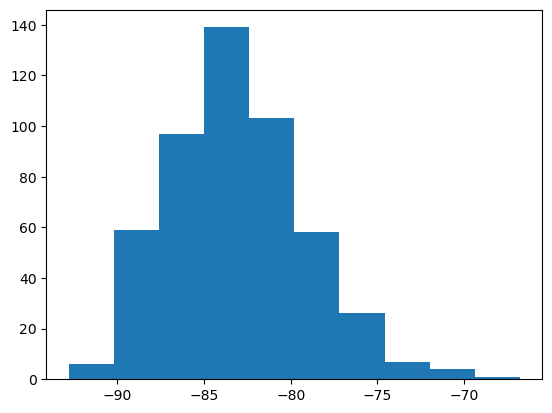

In [21]:
ens = [compute_energy(h,J,eq_seq[i,:]) for i in 1:Nsamples]
hist(ens)
savefig("energies.png")

In [22]:
scatter(ens,cie)

LoadError: UndefVarError: `cie` not defined

In [41]:
cie_old = [0.22364166448448083, 0.35081592989560484, 0.3431229071320203, 0.9915697693063807, 0.8954686411420223, 0.972108503637691, 0.8175566363115494, 0.9743523445292506, 0.40918740502952844, 0.7138555955076475, 0.9970433402104208, 0.9209394481940656, 0.2140710681042187, 0.9410105056689646, 0.2513881446901185, 0.26034062501245037, 0.4297586093037604, 0.15252732850878192, 0.06722154475830686, 0.11835001140827503, 0.8385800999954849, 0.8954686411420223, 0.38792567937193734, 0.8112781244591328, 0.06722154475830686, 0.13005884617909685, 0.8414646362081757, 0.7056366064601749, 0.675682186163725, 0.41611895125187054, 0.7916985001248851, 
    0.9915697693063807, 0.31135737042928313, 0.0, 0.6197604376555947, 0.36592365090022316, 0.883721961491576, 0.26915586965420646, 0.09377790984777166, 0.9994343896240241, 0.9169567260822411, 0.0, 0.49385372369952063, 0.26915586965420646, 0.2043246709802796, 0.5736665363828041, 0.908678384800712, 0.7638026659331062, 0.020814071335501033, 0.7745085286615678, 0.5683070291874017, 0.2948328193632007, 0.020814071335501033, 0.020814071335501033, 0.15252732850878192, 0.9949041692998883, 0.0, 0.4561861025695263, 0.8788323569105614, 0.4021791902022728, 0.6930283686032682, 0.17391711692221742, 0.06722154475830686, 0.6246538232507122, 0.6295033782281994, 0.932269191548067, 0.037622360322278434, 0.8206501291977117, 0.06722154475830686, 0.09377790984777166, 0.9491240519851774, 0.8661236813986259, 0.4815485438118001, 0.303151590366192, 0.14144054254182067, 0.6972688157923281, 0.8499431123430717, 0.4021791902022728, 0.499915958164528, 0.4297586093037604, 0.0, 0.9228919718923305, 0.0, 0.7014714598838974, 0.0, 0.2043246709802796, 0.48773158354050183, 0.8237133233102514, 0.5059192440727412, 0.9814538950336537, 0.4753035717834445, 0.23304589256445052, 0.11835001140827503, 0.7983504203079476, 0.38792567937193734, 0.36592365090022316, 0.24229218908241482, 0.8712907840103599, 0.17391711692221742, 0.5407504779634866]

100-element Vector{Float64}:
 0.22364166448448083
 0.35081592989560484
 0.3431229071320203
 0.9915697693063807
 0.8954686411420223
 0.972108503637691
 0.8175566363115494
 0.9743523445292506
 0.40918740502952844
 0.7138555955076475
 0.9970433402104208
 0.9209394481940656
 0.2140710681042187
 ⋮
 0.5059192440727412
 0.9814538950336537
 0.4753035717834445
 0.23304589256445052
 0.11835001140827503
 0.7983504203079476
 0.38792567937193734
 0.36592365090022316
 0.24229218908241482
 0.8712907840103599
 0.17391711692221742
 0.5407504779634866

## Finding critical T of Viana Bray model

In [2]:
using DelimitedFiles

In [4]:
list = readdlm("CouplingsFields_Connectivity4_seed10_L100")
L = 100
J = zeros(L,L)
h = zeros(L)
for n in 1:size(list,1)
    if typeof(list[n,3]) == Float64
        J[list[n,1],list[n,2]] = list[n,3]
        J[list[n,2],list[n,1]] = list[n,3]
    else
        h[list[n,1]] = list[n,2]
    end 
end    

In [5]:
sum(abs2, J - J')

0.0

In [107]:
T = 10.
U, Δ, ev_u, avPert, maxPert = dATlineSearch(30,30,1.,T,h,J);

In [108]:
@time U1, Δ1, ev_u1, avPert1, maxPert1 = dATlineSearch(30,30,1.,T,h,J);

  0.068763 seconds (1.85 M allocations: 52.620 MiB, 20.02% gc time)


In [132]:
Iterations = 50
Ts = [1. - 1e-2 * i for i in 1:100]
res = zeros(Iterations, length(Ts))
res_dU = zeros(length(Ts))


u_init, Δ, ev_u, avPert, maxPert = dATlineSearch(Iterations,Iterations,1.,Ts[1],h,J)
for i in 1:length(Ts)
    U, Δ, ev_u, avPert, maxPert = dATlineSearch(Iterations,Iterations,1.,Ts[i],h,J)
    u_init .= U .+ pert
    res[:,i] .= maxPert    
    res_dU[i] = maximum(U)
    #println(extrema(U))
end
   
    
    

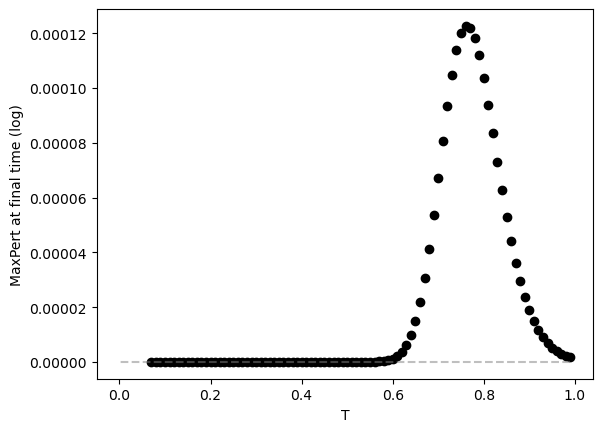

PyObject Text(24.0, 0.5, 'MaxPert at final time (log)')

In [133]:
plt.scatter(Ts, res[end,:], color = "black")
plt.plot(Ts, [0. for i in 1:length(Ts)], color = "grey", linestyle = "--", alpha = 0.5)
#plt.plot([0.6,0.6], [maximum(log.(res[end,:]) for _ in 1:2], color = "grey", linestyle = "--", alpha = 0.5
plt.xlabel("T")
plt.ylabel("MaxPert at final time (log)")
#savefig("Tcrit_VianaBray.png")

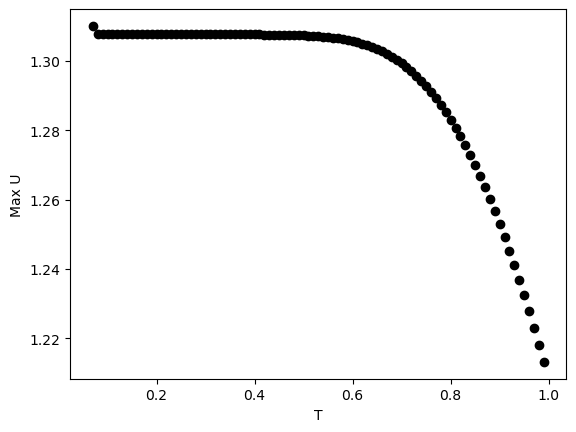

PyObject Text(24.000000000000007, 0.5, 'Max U')

In [134]:
plt.scatter(Ts, res_dU, color = "black")
#plt.plot(Ts, [0. for i in 1:length(Ts)], color = "grey", linestyle = "--", alpha = 0.5)
plt.xlabel("T")
plt.ylabel("Max U")
#savefig("Tcrit_maxU.png")